# **Deep Learning com Keras e Tensor Flow**

![](title.png)

# O que iremos discutir?

 <h3> <p>- Como construir uma CNN usando Keras + Tensorflow</p> <p> - Usando TransferLearning</p>  <p> - Alguns desafios encontrados</p> </h3> <img src="medical-images.png" width=300/>


# Por que Tensorflow + Keras?

- Continuam sendo as bibliotecas mais usadas e mais pesquisadas para Deep Learning

| ![](https://cdn-images-1.medium.com/max/800/1*8cuSvK4Wc5jjJDH8sPCOPw.png) | ![](https://cdn-images-1.medium.com/max/1000/1*FGdwNXVzEno6N3CYBW6OLA.png) |
|:---|---:|

[Fonte](https://towardsdatascience.com/which-deep-learning-framework-is-growing-fastest-3f77f14aa318)

- Muito mais simples do que usar Tensorflow puro e mais completo do que o Pytorch.

# Convolutional Neural Network

- Usadas principalmente para classificação de imagens.

## Como elas funcionam?

 - Filtros convolucionais são usados para extrair features de imagens.

<img src="https://cdn-images-1.medium.com/max/1000/1*TAo3aselJNVwrLLr654Myg.gif" alt="drawing" width="500"/>


Nas redes convolucionais esses filtros são aplicados em várias camadas:

![](https://cdn-images-1.medium.com/max/1600/1*_34EtrgYk6cQxlJ2br51HQ.gif)

Os valores dos filtros são aprendidos, portanto a própria rede aprende quais características são relevantes.

# Construindo uma CNN pra predizer lateralidade do raio-X

Nosso desafio é criar uma rede para aprender se um raio X é lateral ou de frente:

![](lateral.png)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time
import os
import datetime


from keras import datasets, Model
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras import backend
import tensorflow as tf

from keras.preprocessing.image import load_img, img_to_array


Using TensorFlow backend.


## Input de dados

Existem várias formas de inputar os dados para treinamento, vamos usar o `Image Data Generator` para ler as imagens a partir do disco

In [2]:
# aqui definimos as transformações que serão aplicadas na imagem e a % de dados 
# que serão usados para validação
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.30)

In [3]:
# para criar os generators precisamos definir o path da pasta raiz com as imagens e o tamanho da BATCH SIZE
path = 'images-chest-orientation/train/'
BATCH_SIZE = 50

train_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13,
                                    class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(path, shuffle=True, seed=13,
                                    class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 1549 images belonging to 2 classes.
Found 662 images belonging to 2 classes.


## Construindo o modelo:

Vamos criar uma rede pequena que consiga identificar corretamente essas imagens:

In [6]:
def build_model(shape=(256,256)):
    '''
    Constroi as camadas da rede
    :return: modelo construido
    '''
    
    model = Sequential()

    # primeira camada adiciona o shape do input
    # também é possível alterar a inicializacao, bias, entre outros -- https://keras.io/layers/convolutional/#conv2d
    model.add(Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=shape))
    #Tamanho do downsampling
    model.add(MaxPooling2D(pool_size=2))
    # Fracao das unidades que serao zeradas
    model.add(Dropout(0.3))

    # Segunda camada
    model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.3))

    # Da um reshape no output transformando em array
    model.add(Flatten())

    # Camada full-connected 
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    #Camada de saida com o resultado das classes
    model.add(Dense(2, activation='sigmoid'))

    return model

In [7]:
model = build_model(shape)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     32896     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 524288)            0         
__________

# Compilação

Precisamos definir como a rede irá aprender: função de loss e otimizador

In [8]:
# Compila o modelo definindo: otimizador, metrica e loss function
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

## Treinamento

Como lemos os dados usando um generator, o fit do keras também será usando um `fit_generator`.

Também usaremos alguns `callbacks`: 
 - ModelCheckPoint para salvar o modelo que tiver o melhor loss durante o treinamento e,
 - EarlyStop para interromper o treinamento caso a rede pare de aprender.

In [9]:
checkpoint = ModelCheckpoint('chest_orientation_model.hdf5', 
                             monitor='val_loss', 
                             verbose=1, mode='min', 
                             save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                                   min_delta=0.001,
                                   patience=5,
                                   mode='min',
                                   verbose=1)

In [10]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch = train_generator.samples//BATCH_SIZE,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//BATCH_SIZE,
                    epochs= 50,
                    callbacks=[checkpoint, early_stop]
                    )

Epoch 1/50
30/30 [==============================] - 544s 18s/step - loss: 2.7752 - acc: 0.7283 - val_loss: 0.3751 - val_acc: 0.8677

Epoch 00001: val_loss improved from inf to 0.37515, saving model to chest_orientation_model.hdf5
Epoch 2/50
30/30 [==============================] - 603s 20s/step - loss: 0.1330 - acc: 0.9533 - val_loss: 0.1346 - val_acc: 0.9518

Epoch 00002: val_loss improved from 0.37515 to 0.13461, saving model to chest_orientation_model.hdf5
Epoch 3/50
30/30 [==============================] - 624s 21s/step - loss: 0.0696 - acc: 0.9750 - val_loss: 0.0957 - val_acc: 0.9812

Epoch 00003: val_loss improved from 0.13461 to 0.09569, saving model to chest_orientation_model.hdf5
Epoch 4/50
30/30 [==============================] - 569s 19s/step - loss: 0.0358 - acc: 0.9903 - val_loss: 0.0968 - val_acc: 0.9714

Epoch 00004: val_loss did not improve from 0.09569
Epoch 5/50
30/30 [==============================] - 538s 18s/step - loss: 0.0231 - acc: 0.9917 - val_loss: 0.0642 - va

## Avaliação:

Sempre importante separar uma quantidade de dados para testar o modelo no final. Aqui faremos apenas um teste visual para efeito de demonstração

In [3]:
# Carregando imagens de teste
import glob

test_set = glob.glob('images-chest-orientation/test/**/*.jpg')

# temos que fazer o load do model que teve o melhor loss
model = load_model('chest_orientation_model.hdf5')

image_test = np.array([img_to_array(load_img(image_name, target_size=(256, 256), color_mode='rgb'))/255 for image_name in test_set])

y_pred = model.predict(image_test)

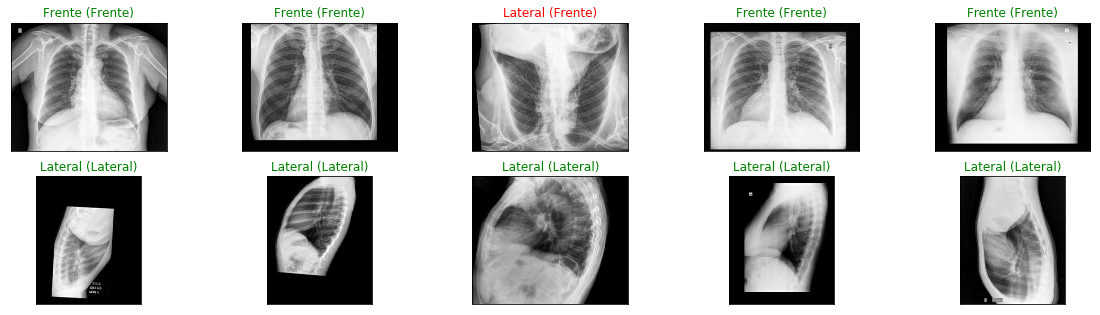

In [4]:
y_true = [0,0,0,0,0,1,1,1,1,1]
labels = ['Frente', 'Lateral']
figure = plt.figure(figsize=(20, 8))
for i in range(10):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    im = plt.imread(test_set[i])
    ax.imshow(im)
    predict_index = np.argmax(y_pred[i])
    true_index = y_true[i]
    # Set the title for each image
    ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

# Latania - criando nossa própria arquitetura

Nosso desafio é um pouco mais difícil do que simplesmente avaliar a lateralidade.

![](https://posterng.netkey.at/esr/viewing/index.php?module=viewimage&task=&maxheight=300&maxwidth=300&mediafile_id=603381&201501050341.gif)
    
- Tentamos resolver inicialmente definindo nossa própria arquitetura de rede: a Latania

# A arquitetura Latania

<img src="latania.png" width=550/>



In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape, name='input_conv', kernel_initializer='he_normal'))

# Performance do modelo

![](results_CNN_opacity.png)


# Salvas pelo Transfer Learning

<img src="https://www.cc.gatech.edu/~hays/compvision2017/proj6/deepNetVis.png">

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from glob import glob 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as Inception
import keras.backend as K
from PIL import Image
IMG_SIZE = (512, 512)


# Input de Dados

Nesse exemplo usaremos `ImageDataGenerator` e `flow_from_datataframe` para detecção de Cardiomegalias

<center><img src="00000008_000.jpg" width=400></center>


In [3]:
core_idg = ImageDataGenerator(samplewise_center=False, 
                              samplewise_std_normalization=False, 
                              horizontal_flip=True, 
                              vertical_flip=False, 
                              height_shift_range=0.1, 
                              width_shift_range=0.1, 
                              brightness_range=[0.7, 1.5],
                              rotation_range=3, 
                              shear_range=0.01,
                              fill_mode='nearest',
                              zoom_range=0.125,
                              rescale = 1./255)

Using TensorFlow backend.


In [4]:
train_data_df = pd.read_csv('cardiomegaly_multilabel_train.csv', 
                            names=['files', 'class'], header=None, sep='\t')
val_data_df = pd.read_csv('cardiomegaly_multilabel_val.csv', 
                          names=['files', 'class'], header=None, sep='\t')



In [5]:
path = 'cardiomegaly_train.csv'
batch_size = 8
img_size = (384,384)

#leitura do csv com os dados usando Pandas
train_data_df = pd.read_csv(path, names=['files', 'class'], header=None, sep='\t')



Found 13763 images belonging to 3 classes.


In [6]:
train_generator = core_idg.flow_from_dataframe(train_data_df, directory=None, x_col='files', 
                                    y_col='class', class_mode='categorical', 
                                    target_size=img_size, batch_size=batch_size)
#checando os índices de cada classe
train_generator.class_indices


{'cardiomegaly': 0, 'non_cardio': 1, 'normal': 2}

In [7]:
valid_generator = core_idg.flow_from_dataframe(val_data_df, directory=None, x_col='files',
                                               y_col='class',  class_mode='categorical',
                                               target_size=(384,384), batch_size=8)

Found 5899 images belonging to 3 classes.


In [8]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as Inception
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.layers import Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model

from keras.optimizers import Adam, SGD

#instanciando o modelo base, nesse caso InceptionResnetv2
base_pretrained_model = Inception(input_shape =  (384,384,3), 
                              include_top = False, weights = 'imagenet')

x = base_pretrained_model.output

#introduzindo as novas camadas densas
x = GlobalAveragePooling2D()(x)
dense_layers = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
dense_layers = Dropout(0.3)(dense_layers)

out_layer = Dense(3, activation = 'sigmoid')(dense_layers)

#modelo final com a arquitetura InceptionResnetv2 e as novas camadas densas
final_model = Model(inputs = [base_pretrained_model.input], outputs = [out_layer], name = 'final_model')

final_model.compile(optimizer = Adam(lr = 1e-3), loss = 'binary_crossentropy',
                           metrics = ['accuracy'])


In [10]:
#Retreinamento das camadas do InceptionResnetv2
base_pretrained_model.trainable = True

# Treinamento

Como lemos os dados usando um generator, o fit do keras também será usando um fit_generator.

Também usaremos alguns callbacks:

**ModelCheckPoint** para salvar o modelo que tiver o melhor loss durante o treinamento,

**EarlyStop** para interromper o treinamento caso a rede pare de aprender e,

**ReduceLROnPlateau** para diminuir a taxa de aprendizagem se o loss da validação não se alterar.



In [ ]:
reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)


In [11]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cardio_multilabel')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)


early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=20) # probably needs to be more patient, but kaggle time is limited

callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/fernanda/tensorflow/lib/python3.5/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [12]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
final_model.fit_generator(train_generator,
                      steps_per_epoch=STEP_SIZE_TRAIN,
                      validation_data = valid_generator, 
                      validation_steps=STEP_SIZE_VALID,
                      epochs = 10, 
                      callbacks = callbacks_list,
                      workers = 3)

Epoch 1/10
1720/1720 [==============================] - 1057s 615ms/step - loss: 0.4994 - acc: 0.7415 - val_loss: 0.4783 - val_acc: 0.7729

Epoch 00001: val_loss improved from inf to 0.47827, saving model to cardio_multilabel_weights.best.hdf5
Epoch 2/10
1720/1720 [==============================] - 920s 535ms/step - loss: 0.4741 - acc: 0.7623 - val_loss: 0.6174 - val_acc: 0.6961

Epoch 00002: val_loss did not improve from 0.47827
Epoch 3/10
1720/1720 [==============================] - 921s 535ms/step - loss: 0.4690 - acc: 0.7661 - val_loss: 0.4439 - val_acc: 0.7895

Epoch 00003: val_loss improved from 0.47827 to 0.44394, saving model to cardio_multilabel_weights.best.hdf5
Epoch 4/10
1720/1720 [==============================] - 921s 536ms/step - loss: 0.4621 - acc: 0.7719 - val_loss: 0.4656 - val_acc: 0.7693

Epoch 00004: val_loss did not improve from 0.44394
Epoch 5/10
1720/1720 [==============================] - 926s 538ms/step - loss: 0.4584 - acc: 0.7744 - val_loss: 0.6266 - val_acc

# Avaliação

Após o término do treinamento usaremos um conjunto de teste independente para avaliar a performance do modelo

In [20]:
path = 'cardiomegaly_test.csv'
df = pd.read_csv(path, names=['files', 'class'], header=None, sep='\t')

#usando as funções de pre processamento do keras para leitura das imagens
from keras.preprocessing.image import load_img, img_to_array

imgs = []
for image_name in df['files'].values:
    img = load_img(image_name, target_size = (384,384), color_mode = 'rgb')
    img_array = img_to_array(img)
    img_array = img_array/255.
    imgs.append(img_array)
imgs = np.array(imgs)

In [21]:
#Carregando o melhor conjunto de pesos 
final_model.load_weights('cardio_multilabel_weights.best.hdf5')

#Realizando a predição no modelo treinado
y_predict = final_model.predict(imgs, verbose=1)

class_pred = []
for pred in y_predict:
    class_number = np.argmax(pred)
    if class_number == 0:
        class_pred.append('cardiomegaly')
    elif class_number == 1:
        class_pred.append('non_cardio')
    else:
        class_pred.append('normal')



3470/3470 [==============================] - 34s 10ms/step


In [22]:
#Definindo os labels reais
y_true = df['class'].values

In [23]:
#Usando o classification report do sklearn pra calcular as estatísticas de performance do modelo

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, class_pred, target_names = ['Cardiomegaly', 'Non_Cardio','Healthy']))

              precision    recall  f1-score   support

Cardiomegaly       0.74      0.82      0.78       848
  Non_Cardio       0.72      0.58      0.64      1254
     Healthy       0.70      0.77      0.73      1368

   micro avg       0.71      0.71      0.71      3470
   macro avg       0.72      0.72      0.72      3470
weighted avg       0.71      0.71      0.71      3470



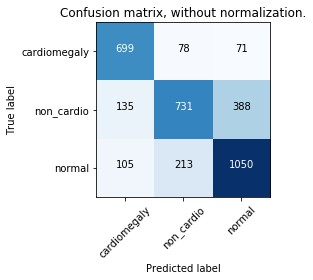

In [24]:
#Plotando a matriz de confusão
class_names=['cardiomegaly', 'non_cardio','normal']
cm=confusion_matrix(y_true, class_pred)
title='Confusion matrix, without normalization.'
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Pontos de atenção

- Normalização dos dados
- Dataset com ruído
- Inicialização dos pesos
- Escolha da função de loss

# Obrigada!

![](https://qconsp.com/sites/default/files/styles/img-speaker-home/public/fernanda.wanderley.jpg?itok=2KDXp2un)

<center><h3>Fernanda Wanderley (fernanda@neuralmed.ai / linkedin: in/nandaw)</h3></center>

![](https://qconsp.com/sites/default/files/styles/img-speaker-home/public/jessica500.png?itok=cbeQRCEa)

<center><h3>Jéssica Santos (jessica@neuralmed.ai / linkedin: in/jessica-santos-oliveira)</h3></center>

### link do repo: https://github.com/nandaw/qcon_notebook